# Use a convolutional neural network (CNN) to detect quasi-linear convective structures

This notebook demonstrates:

1) Reading in a pre-trained keras CNN model

2) Examining the layers of that model

3) Using the positions of intense precipitation as centroids for images to pass into the CNN

4) Examining a few cases to see how the CNN behaves.

# This CNN takes 128 x 128 pixel images (~256 x ~256 km regions) as input

In [1]:
from keras.models import load_model
from utils.img_preproc import special_reshape

pref = 'models/'
model = load_model(pref + 'mcs_model.h5')

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 1, 130, 130)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 124, 124)      3200      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 124, 124)      496       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 122, 122)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 122, 122)      488       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 61, 61)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 63, 63)        0         
__________

# Image preprocessing

Pass the image you want to classify into get_qlcs_locations.

This function does the following tasks:

1) Finds regions of intense rainfall (at least 50 dBZ)

2) Generates a ~256 x ~256 km box around the centroid of each detected region

3) Extracts image data from this box and normalizes the pixel values

4) Passes the image data into the CNN

5) If the predicted probability of 'QLCS' is greater than min_thresh, note the pixel locations

6) Return image of activated pixels

In [2]:
import numpy as np
from skimage.measure import regionprops
from scipy import ndimage

def get_qlcs_locations(analysis_img, cnn_model, min_thresh=10, min_proba=0.5):
    
    out_img = np.zeros(shape=analysis_img.shape, dtype=np.uint8)
        
    labs, num = ndimage.label(analysis_img>=min_thresh, ndimage.generate_binary_structure(2,2))

    regions = regionprops(labs, intensity_image=analysis_img)

    for idx, region in enumerate(regions):

        y, x = region.weighted_centroid

        xmin, xmax = int(x)-64, int(x)+64
        ymin, ymax = int(y)-64, int(y)+64

        im = analysis_img[ymin:ymax, xmin:xmax]

        data = np.zeros(shape=[1, 1, 128, 128])
        data[0, 0, :, :] = (im**2) / 256
        pred = cnn_model.predict_proba(data)

        if pred[0][1] >= min_proba:
            
            y, x = region.coords[:, 0], region.coords[:, 1]
            out_img[y, x] = 1
                        
    return out_img

# Read in data from "Super Derecho" event in May 2009

In [3]:
from imageio import imread
from scipy.ndimage import binary_dilation
import numpy as np

img = imread("../data/radar_data/BREF_090508_1300.png", pilmode='P')
img[img < 4] = 0
out_img = get_qlcs_locations(img, model)

out_img = binary_dilation(out_img, structure=np.ones((3,3)), iterations=10)

Text(0.5,1,'Reflectivity valid at 1300 UTC on 8 May 2009')

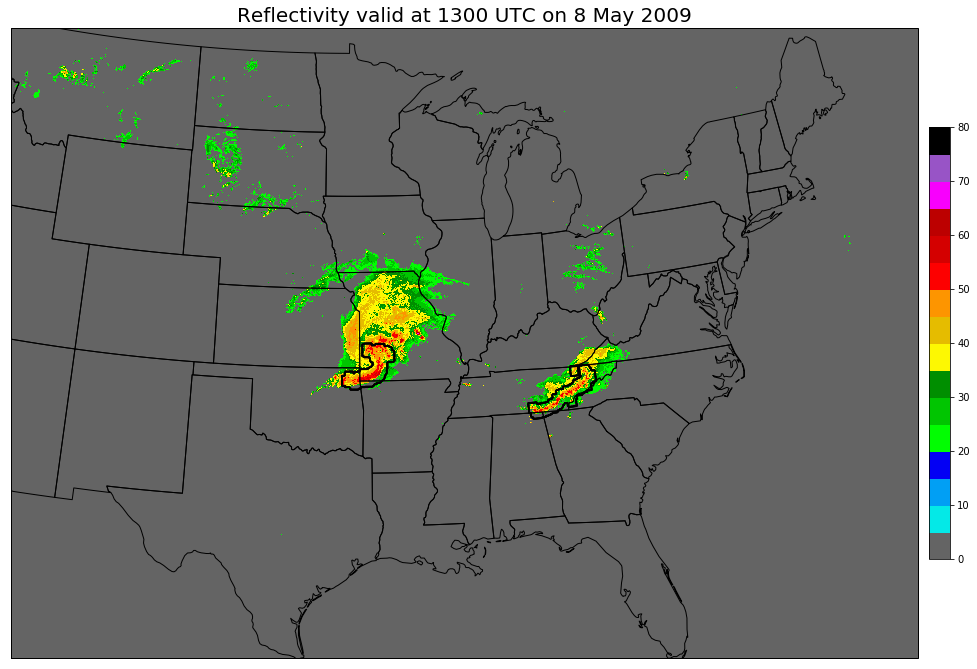

In [4]:
from utils.mapping_help import *
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from utils.colors import radar_colormap

%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 15

to_proj = ccrs.AlbersEqualArea(central_longitude=-95, central_latitude=38.0000)
from_proj = ccrs.PlateCarree()

view = generate_view(-110, -70, 25, 48, from_proj, to_proj)

cmap = radar_colormap()
classes = list(range(0, 85, 5))
norm = BoundaryNorm(classes, ncolors=cmap.N, clip=True)
lons, lats = get_NOWrad_conus_lon_lat()
lons, lats = np.meshgrid(lons, lats)
mmp = view.pcolormesh(lons, lats, img*5, cmap=cmap, norm=norm, transform=from_proj)

plt.colorbar(mmp, ax=view, shrink=0.4, pad=0.01)

view.contour(lons, lats, out_img, colors=['k',], transform=from_proj)

plt.title("Reflectivity valid at 1300 UTC on 8 May 2009", fontsize=20)

# Find a more mundane squall line

In [5]:
img = imread("../data/radar_data/BREF_080606_0200.png", pilmode='P')
img[img < 4] = 0
out_img = get_qlcs_locations(img, model)

out_img = binary_dilation(out_img, structure=np.ones((3,3)), iterations=10)

Text(0.5,1,'Reflectivity valid at 200 UTC on 6 June 2008')

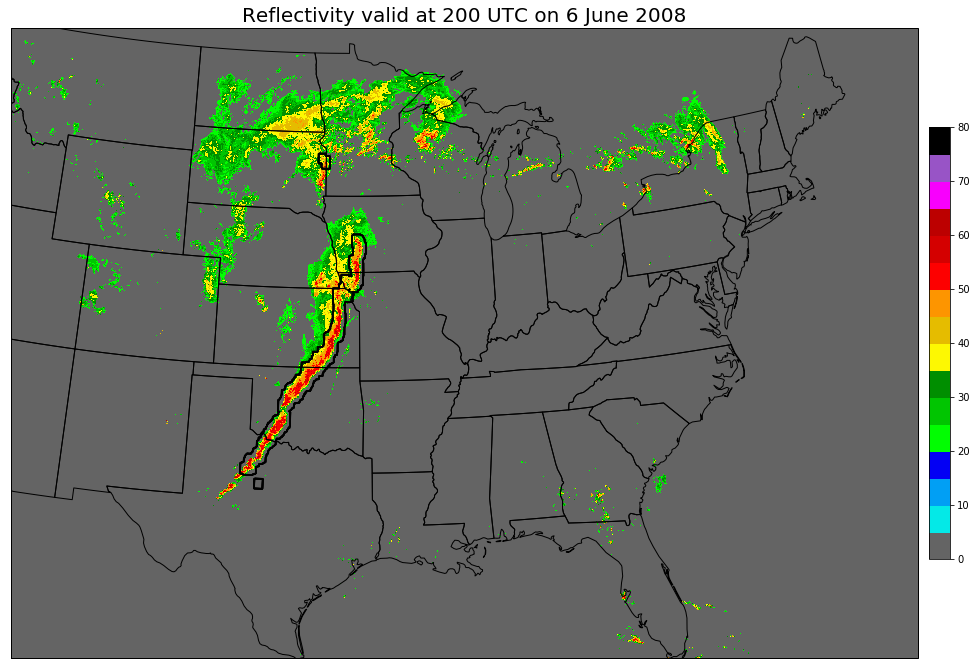

In [6]:
from utils.mapping_help import *
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from utils.colors import radar_colormap

%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 15

to_proj = ccrs.AlbersEqualArea(central_longitude=-95, central_latitude=38.0000)
from_proj = ccrs.PlateCarree()

view = generate_view(-110, -70, 25, 48, from_proj, to_proj)

cmap = radar_colormap()
classes = list(range(0, 85, 5))
norm = BoundaryNorm(classes, ncolors=cmap.N, clip=True)
lons, lats = get_NOWrad_conus_lon_lat()
lons, lats = np.meshgrid(lons, lats)
mmp = view.pcolormesh(lons, lats, img*5, cmap=cmap, norm=norm, transform=from_proj)

plt.colorbar(mmp, ax=view, shrink=0.4, pad=0.01)

view.contour(lons, lats, out_img, colors=['k',], transform=from_proj)

plt.title("Reflectivity valid at 200 UTC on 6 June 2008", fontsize=20)

# Examine April 27th 2011 Evolution

How well does the model work with a complex scenario?

# Read in data from 1000 UTC on April 27th

In [7]:
img = imread("../data/radar_data/BREF_110427_1000.png", pilmode='P')
img[img < 4] = 0
out_img = get_qlcs_locations(img, model)

out_img = binary_dilation(out_img, structure=np.ones((3,3)), iterations=10)

Text(0.5,1,'Reflectivity valid at 1000 UTC on 27 April 2011')

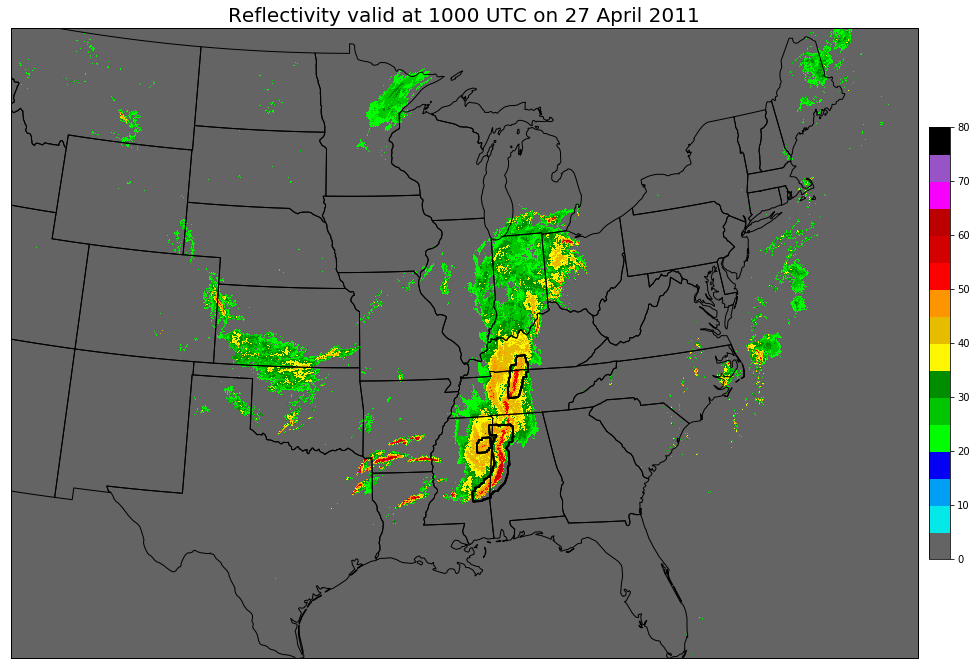

In [8]:
from utils.mapping_help import *
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from utils.colors import radar_colormap

%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 15

to_proj = ccrs.AlbersEqualArea(central_longitude=-95, central_latitude=38.0000)
from_proj = ccrs.PlateCarree()

view = generate_view(-110, -70, 25, 48, from_proj, to_proj)

cmap = radar_colormap()
classes = list(range(0, 85, 5))
norm = BoundaryNorm(classes, ncolors=cmap.N, clip=True)
lons, lats = get_NOWrad_conus_lon_lat()
lons, lats = np.meshgrid(lons, lats)
mmp = view.pcolormesh(lons, lats, img*5, cmap=cmap, norm=norm, transform=from_proj)

plt.colorbar(mmp, ax=view, shrink=0.4, pad=0.01)

view.contour(lons, lats, out_img, colors=['k',], transform=from_proj)

plt.title("Reflectivity valid at 1000 UTC on 27 April 2011", fontsize=20)

# Read in data from 1600 UTC on April 27th

In [9]:
img = imread("../data/radar_data/BREF_110427_1600.png", pilmode='P')
img[img < 4] = 0
out_img = get_qlcs_locations(img, model)

out_img = binary_dilation(out_img, structure=np.ones((3,3)), iterations=10)

Text(0.5,1,'Reflectivity valid at 1600 UTC on 27 April 2011')

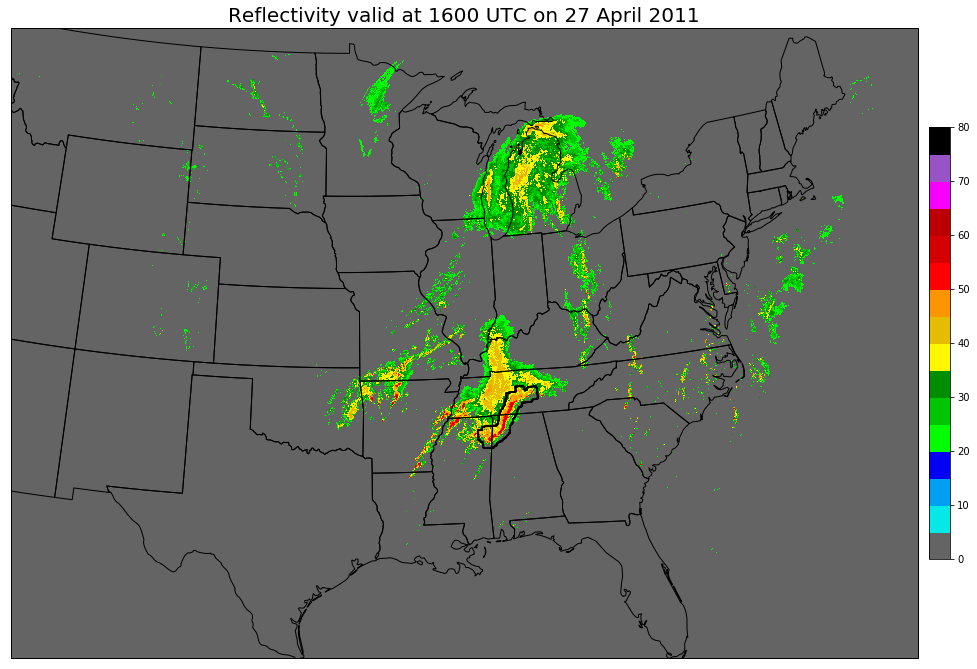

In [10]:
from utils.mapping_help import *
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from utils.colors import radar_colormap

%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 15

to_proj = ccrs.AlbersEqualArea(central_longitude=-95, central_latitude=38.0000)
from_proj = ccrs.PlateCarree()

view = generate_view(-110, -70, 25, 48, from_proj, to_proj)

cmap = radar_colormap()
classes = list(range(0, 85, 5))
norm = BoundaryNorm(classes, ncolors=cmap.N, clip=True)
lons, lats = get_NOWrad_conus_lon_lat()
lons, lats = np.meshgrid(lons, lats)
mmp = view.pcolormesh(lons, lats, img*5, cmap=cmap, norm=norm, transform=from_proj)

plt.colorbar(mmp, ax=view, shrink=0.4, pad=0.01)

view.contour(lons, lats, out_img, colors=['k',], transform=from_proj)

plt.title("Reflectivity valid at 1600 UTC on 27 April 2011", fontsize=20)

# Read in data from 2000 UTC on April 27th

In [11]:
img = imread("../data/radar_data/BREF_110427_2000.png", pilmode='P')
img[img < 4] = 0
out_img = get_qlcs_locations(img, model)

out_img = binary_dilation(out_img, structure=np.ones((3,3)), iterations=10)

Text(0.5,1,'Reflectivity valid at 2000 UTC on 27 April 2011')

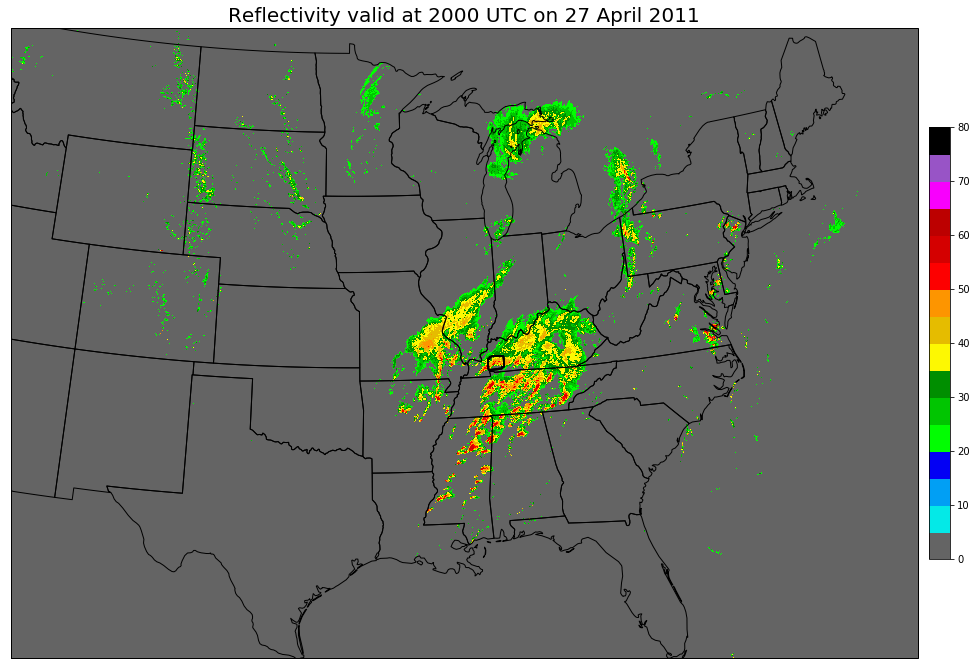

In [12]:
from utils.mapping_help import *
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from utils.colors import radar_colormap

%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 15

to_proj = ccrs.AlbersEqualArea(central_longitude=-95, central_latitude=38.0000)
from_proj = ccrs.PlateCarree()

view = generate_view(-110, -70, 25, 48, from_proj, to_proj)

cmap = radar_colormap()
classes = list(range(0, 85, 5))
norm = BoundaryNorm(classes, ncolors=cmap.N, clip=True)
lons, lats = get_NOWrad_conus_lon_lat()
lons, lats = np.meshgrid(lons, lats)
mmp = view.pcolormesh(lons, lats, img*5, cmap=cmap, norm=norm, transform=from_proj)

plt.colorbar(mmp, ax=view, shrink=0.4, pad=0.01)

view.contour(lons, lats, out_img, colors=['k',], transform=from_proj)

plt.title("Reflectivity valid at 2000 UTC on 27 April 2011", fontsize=20)

# Read in data from 2100 UTC on April 27th

In [13]:
img = imread("../data/radar_data/BREF_110427_2100.png", pilmode='P')
img[img < 4] = 0
out_img = get_qlcs_locations(img, model)

out_img = binary_dilation(out_img, structure=np.ones((3,3)), iterations=10)

C:\Users\ahaberlie\Anaconda3\envs\tensorflow2\lib\site-packages\matplotlib\contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


Text(0.5,1,'Reflectivity valid at 2100 UTC on 27 April 2011')

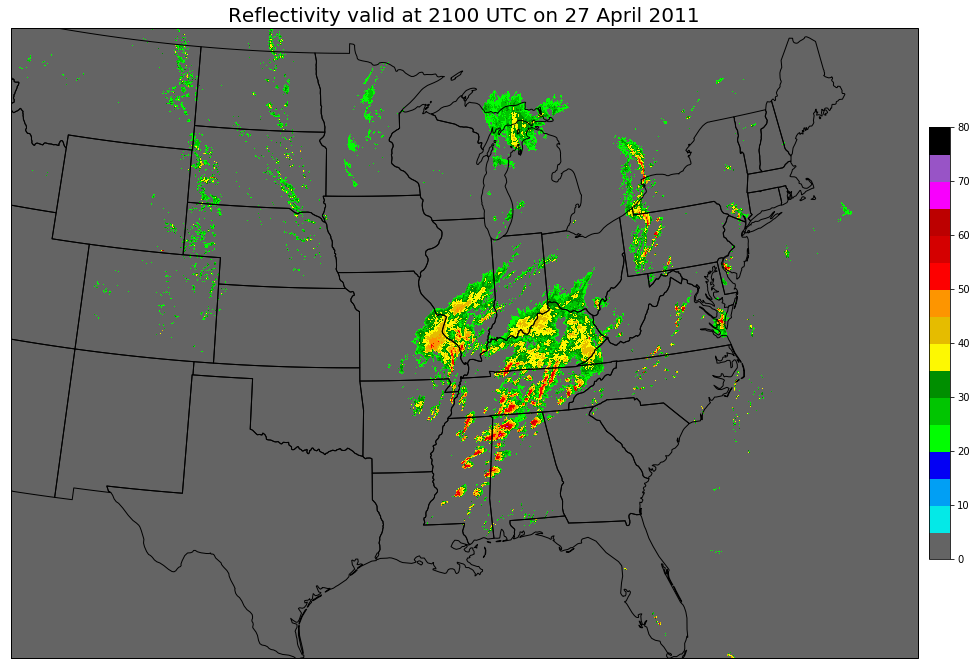

In [14]:
from utils.mapping_help import *
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from utils.colors import radar_colormap

%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 15

to_proj = ccrs.AlbersEqualArea(central_longitude=-95, central_latitude=38.0000)
from_proj = ccrs.PlateCarree()

view = generate_view(-110, -70, 25, 48, from_proj, to_proj)

cmap = radar_colormap()
classes = list(range(0, 85, 5))
norm = BoundaryNorm(classes, ncolors=cmap.N, clip=True)
lons, lats = get_NOWrad_conus_lon_lat()
lons, lats = np.meshgrid(lons, lats)
mmp = view.pcolormesh(lons, lats, img*5, cmap=cmap, norm=norm, transform=from_proj)

plt.colorbar(mmp, ax=view, shrink=0.4, pad=0.01)

view.contour(lons, lats, out_img, colors=['k',], transform=from_proj)

plt.title("Reflectivity valid at 2100 UTC on 27 April 2011", fontsize=20)